<a href="https://colab.research.google.com/github/DmitryKutsev/NIS_SentiFrame/blob/master/skipgram_research_18_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%%capture
!pip install pymorphy2[fast]

In [0]:
import gensim
from collections import Counter
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from sklearn.metrics.pairwise import cosine_similarity
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

In [0]:
%%capture
# at least two mutual negative attitudes
!wget https://raw.githubusercontent.com/DmitryKutsev/NIS_SentiFrame/master/grouped_verb_lists/neg_a0_a1_mutual.json
!wget https://raw.githubusercontent.com/DmitryKutsev/NIS_SentiFrame/master/grouped_verb_lists/neg_a0_a2_mutual.json
!wget https://raw.githubusercontent.com/DmitryKutsev/NIS_SentiFrame/master/grouped_verb_lists/neg_a1_a2_mutual.json

# at least two mutual positive attitudes
!wget https://raw.githubusercontent.com/DmitryKutsev/NIS_SentiFrame/master/grouped_verb_lists/pos_a0_a1_mutual.json
!wget https://raw.githubusercontent.com/DmitryKutsev/NIS_SentiFrame/master/grouped_verb_lists/pos_a0_a2_mutual.json
!wget https://raw.githubusercontent.com/DmitryKutsev/NIS_SentiFrame/master/grouped_verb_lists/pos_a1_a2_mutual.json

# at least two opposite attitudes (only a0/a1 show opposite attitudes toward each other)
!wget https://raw.githubusercontent.com/DmitryKutsev/NIS_SentiFrame/master/grouped_verb_lists/opp_a0_a1_candidates_l.json

In [0]:
# !wget https://raw.githubusercontent.com/nicolay-r/RuSentiFrames/master/collection.json
with open("collection.json", "r", encoding="utf-8") as f:
  collection = json.load(f)
# !rm collection.json

In [0]:
%%capture
# taiga model
!wget http://vectors.nlpl.eu/repository/20/185.zip

In [9]:
import zipfile
model_url = 'http://vectors.nlpl.eu/repository/20/185.zip'
# m = wget.download(model_url)
model_file = model_url.split('/')[-1]
with zipfile.ZipFile(model_file, 'r') as archive:
    stream = archive.open('model.bin')
    skipgram_model = gensim.models.KeyedVectors.load_word2vec_format(stream, binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
def make_seed_embedding(seed_dict, model):
  '''
  Принимает на вход список, на выходе дает средний вектор всех слов из этого списка
  '''
  summ = 0
  if model == skipgram_model:
    for verb in seed_dict:
      summ = summ + model[verb + '_VERB']
    return summ/len(seed_dict)

#Добавим близость к оси

In [0]:
!wget https://github.com/DmitryKutsev/NIS_SentiFrame/raw/master/annotations/polarity_annotation/3annotators_agree_on_these.zip
!unzip 3annotators_agree_on_these.zip
!rm 3annotators_agree_on_these.zip

In [0]:
where_csv_is = 'https://raw.githubusercontent.com/DmitryKutsev/\
NIS_SentiFrame/master/annotations/SENTIFRAME%20-%20case_annotation.csv'
df = pd.read_csv(where_csv_is)
columns2drop = ['polar_or_not', 'polarity_dima', 'polarity_ira', 
                'падеж первого аргумента, по умолчанию nomn', 
                'падеж второго аргумента в нотации pymorphy2, по умолчанию accs', 
                'rel(А0,A1)', 'rel(А1,A0)']
df.drop(columns2drop, axis=1, inplace=True)
df.rename(columns={"polarity_masha": "annotation_polarity"}, inplace=True)

#Axis approach

In [0]:
def compare2axis(word_list, 
                 positive_seed_list, negative_seed_list, 
                 model=skipgram_model):
    p_seed_emb = make_seed_embedding(positive_seed_list, model=model)
    n_seed_emb = make_seed_embedding(negative_seed_list, model=model)
    seed_axis = p_seed_emb - n_seed_emb
    return cosine_similarity(
        np.atleast_2d(make_seed_embedding(word_list, model=model)), 
        np.atleast_2d(seed_axis))[0][0]

In [0]:
def survey(results, category_names):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.get_cmap('RdYlGn')(
        np.linspace(0.15, 0.85, data.shape[1]))

    fig, ax = plt.subplots(figsize=(9.2, 5))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        ax.barh(labels, widths, left=starts, height=0.5,
                label=colname, color=color)
        xcenters = starts + widths / 2

        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
        for y, (x, c) in enumerate(zip(xcenters, widths)):
            # ax.text(x, y, str(int(c)), ha='center', va='center',
            ax.text(x, y, str(round(c, 2)), ha='center', va='center',
                    color=text_color)
    ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='large')

    return fig, ax

In [0]:
def percentage(pd_df, less_than=True, threshold=0.2):
    total = len(pd_df)
    if less_than:
        return len(pd_df[(pd_df['skipgram_axis_similarity']<threshold)])/total
    else:
        return len(pd_df[(pd_df['skipgram_axis_similarity']>threshold)])/total

def draw_bars(pd_df, threshold=0.2, list_description='annotated_',
              categories = ('neg_labels, %', 'pos_labels, %')):
    results = {}
    for polarity in range(0, 2):
        percentage_list = []
        sub_df = pd_df[pd_df['annotation_polarity']==polarity]
        for direction in [True, False]:
            percentage_list.append(percentage(sub_df, less_than=direction, 
                                            threshold=threshold))
        results.update({'{}{}'.format(list_description, polarity):percentage_list})
    return results, list(categories)

In [0]:
def plot_with_seeds(pd_df, threshold, p_seed, n_seed, 
                    model=skipgram_model, where_word_is='verb'):
    pd_df['skipgram_axis_similarity'] = pd_df[where_word_is].apply(
        lambda x: compare2axis([x], p_seed, n_seed, model=model))
    results, category_names = draw_bars(pd_df=pd_df, threshold=threshold)
    survey(results, category_names)
    plt.show()

In [0]:
p_multi_seed = ['одобрять', 'хвалить', 'поощрять', 'любить']
n_multi_seed = ['ненавидеть', 'убить', 'ругать', 'злиться']
p_single_seed = ['ценить']
n_single_seed = ['ненавидеть']
# n_single_seed = ['убивать']

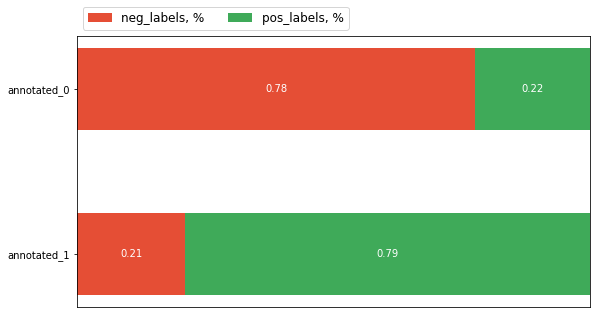

In [188]:
plot_with_seeds(pd_df=df, threshold=-0.018, 
                p_seed=p_single_seed, n_seed=n_single_seed)

In [0]:
p_multi_seed = ['одобрять', 'хвалить', 'поощрять', 'любить']
n_multi_seed = ['ненавидеть', 'убить', 'ругать', 'злиться']

for thres in np.arange(-0.2, 0.2, 0.001):
    print(round(thres, 4))
    plot_with_seeds(pd_df=df, threshold=thres, 
                    p_seed=p_multi_seed, n_seed=n_multi_seed)
# -0.07

In [0]:
p_multi_seed = ['одобрять', 'хвалить', 'поощрять', 'любить',
                'обожать', 'восхищаться', 'восторгаться', 'гордиться',
                'ценить','превозносить',]
n_multi_seed = ['ненавидеть', 'ругать', 'злиться', 'порицать', 
                'осуждать', 'негодовать', 'обвинять', 'наказывать', 
                'убивать', 'разрушать',]

for thres in np.arange(-0.2, 0.2, 0.001):
    print(round(thres, 4))
    plot_with_seeds(pd_df=df, threshold=thres, 
                    p_seed=p_multi_seed, n_seed=n_multi_seed)

# -0.049